# Data Science

### Import packages

In [1]:
import time
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection, naive_bayes, svm

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

### Ignore plotting warnings

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Metrics function

* Generic function for calculating the number of class ratios
* Precision, Recall, F1
* Accuracy 

In [3]:
def model_metrics(Train_Y, Test_Y, predictions):
    """
    Calculate precision, recall, f1 value and accuracy

    """
    print('===================================\n')
    print("Train target values count: ", Counter(Train_Y))
    print("Test target values count: ", Counter(Test_Y))
    print("Result values count: ", Counter(predictions))
    print('\n', metrics.classification_report(Test_Y, predictions))
    print("Accuracy Score: ",accuracy_score(predictions, Test_Y)*100)

## Import data

* Data wrangling
* Includes oversampling and undersampling for managing unbalanced classes

NEGATIVE       2271
NONNEGATIVE    1121
Name: Positivity, dtype: int64


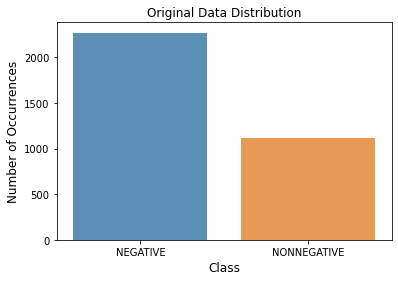

In [4]:

np.random.seed(42)

absolute = 'C:\\Users\\usisavac\\Python\\Diplomski_Rad\\'

path = absolute + 'data\\portal_articles_classes.csv'

data = pd.read_csv(path, encoding='utf-8')
data = data.dropna(subset = ['Title_positivity_sentence', 'Subtitle_positivity_sentence', 'Text_positivity_sentence'])

class_count_df = data['Positivity'].value_counts()
print(class_count_df)

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.title('Original Data Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show();


### Dataset balancing

NEGATIVE       2000
NONNEGATIVE    1500
Name: Positivity, dtype: int64


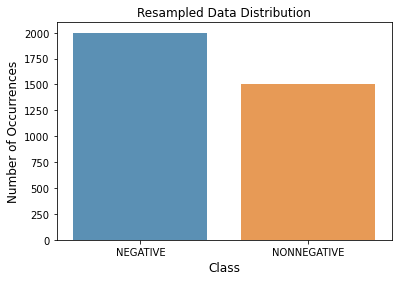

In [5]:

data_non_negative = data[data['Positivity'] == 'NONNEGATIVE']
data_negative = data[data['Positivity'] == 'NEGATIVE']

# Downsample majority class
data_negative_downsampled = resample(data_negative, 
                                 replace=False,    # sample without replacement
                                 n_samples=2000,     # to match minority class
                                 random_state=42) # reproducible results


 
# Upsample minority class
data_non_negative_upsampled = resample(data_non_negative, 
                                 replace=True,     # sample with replacement
                                 n_samples=1500,    # to match majority class
                                 random_state=42) # reproducible results 
# Combine minority class with downsampled majority class
data = pd.concat([data_negative_downsampled, data_non_negative_upsampled])

class_count_df = data['Positivity'].value_counts()
print(class_count_df)

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.title('Resampled Data Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()


## Training and testing split

In [6]:
start_time = time.time()

# Train and test set
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['Article_text'], data['Positivity'], test_size=0.3, stratify=data['Positivity'])

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['Article_text'].values.astype('U'))
X_train_Tfidf = Tfidf_vect.transform(X_train.values.astype('U'))
X_test_Tfidf = Tfidf_vect.transform(X_test.values.astype('U'))

print("\n\nComputed in %s seconds." % (time.time() - start_time))




Computed in 5.42673659324646 seconds.


In [7]:
start_time = time.time()

# Train and test set
X_train_title, X_test_title, Y_train_title, Y_test_title = model_selection.train_test_split(data['Title'], data['Positivity'], test_size=0.3, stratify=data['Positivity'])

X_train_Tfidf_title = Tfidf_vect.transform(X_train_title.values.astype('U'))
X_test_Tfidf_title = Tfidf_vect.transform(X_test_title.values.astype('U'))

print("\n\nComputed in %s seconds." % (time.time() - start_time))



Computed in 0.13364195823669434 seconds.


## K-Fold CV Setup

In [8]:
kfold = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)

## Naive Bayes

### Resampled

In [9]:
start_time = time.time()

def naive_bayes_function(X_train_Tfidf, X_test_Tfidf, Y_train, Y_test):

    NB = naive_bayes.MultinomialNB()
    NB.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
    NB_prediction = NB.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

    # Cross validation
    NB_results_k_fold = model_selection.cross_val_score(NB, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)

    print('\nNaive Bayes:')
    model_metrics(Y_train, Y_test, NB_prediction)

    print("Accuracy(K-Fold): %.3f (%.3f)" % (NB_results_k_fold.mean()*100, NB_results_k_fold.std()))

    return NB




print('\nTitle:')
NB_model_title = naive_bayes_function(X_train_Tfidf_title, X_test_Tfidf_title, Y_train_title, Y_test_title)
print('\nArticle text:')
NB_model_text = naive_bayes_function(X_train_Tfidf, X_test_Tfidf, Y_train, Y_test)

print("\n\nComputed in %s seconds." % (time.time() - start_time))



Title:

Naive Bayes:

Train target values count:  Counter({'NEGATIVE': 1400, 'NONNEGATIVE': 1050})
Test target values count:  Counter({'NEGATIVE': 600, 'NONNEGATIVE': 450})
Result values count:  Counter({'NEGATIVE': 707, 'NONNEGATIVE': 343})

               precision    recall  f1-score   support

    NEGATIVE       0.76      0.89      0.82       600
 NONNEGATIVE       0.81      0.62      0.70       450

    accuracy                           0.77      1050
   macro avg       0.78      0.75      0.76      1050
weighted avg       0.78      0.77      0.77      1050

Accuracy Score:  77.23809523809524
Accuracy(K-Fold): 78.327 (0.015)

Article text:

Naive Bayes:

Train target values count:  Counter({'NEGATIVE': 1400, 'NONNEGATIVE': 1050})
Test target values count:  Counter({'NEGATIVE': 600, 'NONNEGATIVE': 450})
Result values count:  Counter({'NEGATIVE': 600, 'NONNEGATIVE': 450})

               precision    recall  f1-score   support

    NEGATIVE       0.80      0.80      0.80       600

## Support Vector Machine 

### Resampled

In [10]:

start_time = time.time()

def svm_function(X_train_Tfidf, X_test_Tfidf, Y_train, Y_test):

    # Classifier - Algorithm - SVM
    SVM = svm.SVC(C=1.0, kernel='linear', class_weight='balanced', probability=True, degree=3, gamma='auto')

    #Cross validation
    SVM_results_k_fold = model_selection.cross_val_score(SVM, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)

    SVM.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
    SVM_prediction = SVM.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

    print('\nSVM (Default):')
    model_metrics(Y_train, Y_test, SVM_prediction)

    print("Accuracy(K-Fold): %.3f (%.3f)" % (SVM_results_k_fold.mean()*100, SVM_results_k_fold.std()))

    return SVM



print('\nTitle:')
SVM_prediction_title = svm_function(X_train_Tfidf_title, X_test_Tfidf_title, Y_train_title, Y_test_title)
print('\nArticle text:')
SVM_prediction_text = svm_function(X_train_Tfidf, X_test_Tfidf, Y_train, Y_test)

print("\n\nComputed in %s seconds." % (time.time() - start_time))




Title:

SVM (Default):

Train target values count:  Counter({'NEGATIVE': 1400, 'NONNEGATIVE': 1050})
Test target values count:  Counter({'NEGATIVE': 600, 'NONNEGATIVE': 450})
Result values count:  Counter({'NEGATIVE': 584, 'NONNEGATIVE': 466})

               precision    recall  f1-score   support

    NEGATIVE       0.82      0.80      0.81       600
 NONNEGATIVE       0.74      0.77      0.76       450

    accuracy                           0.79      1050
   macro avg       0.78      0.79      0.79      1050
weighted avg       0.79      0.79      0.79      1050

Accuracy Score:  78.85714285714286
Accuracy(K-Fold): 79.878 (0.005)

Article text:

SVM (Default):

Train target values count:  Counter({'NEGATIVE': 1400, 'NONNEGATIVE': 1050})
Test target values count:  Counter({'NEGATIVE': 600, 'NONNEGATIVE': 450})
Result values count:  Counter({'NEGATIVE': 571, 'NONNEGATIVE': 479})

               precision    recall  f1-score   support

    NEGATIVE       0.86      0.82      0.84      

## Random Forest

### Resampled

In [11]:
start_time = time.time()


def rf_function(X_train_Tfidf, X_test_Tfidf, Y_train, Y_test):

    RF = RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=42)

    # Cross validation
    RF_results_k_fold = model_selection.cross_val_score(RF, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)

    RF.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
    RF_prediction = RF.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

    print('\nRandom Forest (Resampled):')
    model_metrics(Y_train, Y_test, RF_prediction)

    print("Accuracy(K-Fold): %.3f (%.3f)" % (RF_results_k_fold.mean()*100, RF_results_k_fold.std()))

    return RF

print('\nTitle:')
RF_model_title = rf_function(X_train_Tfidf_title, X_test_Tfidf_title, Y_train_title, Y_test_title)
print('\nArticle text:')
RF_model_text = rf_function(X_train_Tfidf, X_test_Tfidf, Y_train, Y_test)

print("\n\nComputed in %s seconds." % (time.time() - start_time))


Title:

Random Forest (Resampled):

Train target values count:  Counter({'NEGATIVE': 1400, 'NONNEGATIVE': 1050})
Test target values count:  Counter({'NEGATIVE': 600, 'NONNEGATIVE': 450})
Result values count:  Counter({'NEGATIVE': 666, 'NONNEGATIVE': 384})

               precision    recall  f1-score   support

    NEGATIVE       0.83      0.92      0.87       600
 NONNEGATIVE       0.88      0.75      0.81       450

    accuracy                           0.85      1050
   macro avg       0.85      0.83      0.84      1050
weighted avg       0.85      0.85      0.84      1050

Accuracy Score:  84.57142857142857
Accuracy(K-Fold): 82.408 (0.011)

Article text:

Random Forest (Resampled):

Train target values count:  Counter({'NEGATIVE': 1400, 'NONNEGATIVE': 1050})
Test target values count:  Counter({'NEGATIVE': 600, 'NONNEGATIVE': 450})
Result values count:  Counter({'NEGATIVE': 629, 'NONNEGATIVE': 421})

               precision    recall  f1-score   support

    NEGATIVE       0.87  

In [12]:
path = absolute + 'data\\portal_articles_classes.csv'

df_final = pd.read_csv(path)

Tfidf_vect_f = TfidfVectorizer(max_features=5000)
Tfidf_vect_f.fit(df_final['Article_text'].values.astype('U'))

X_test_Tfidf_actual_text = Tfidf_vect.transform(df_final['Article_text'].values.astype('U'))
X_test_Tfidf_actual_title = Tfidf_vect.transform(df_final['Title'].values.astype('U'))

rf_predict_actual_title = RF_model_title.predict(X_test_Tfidf_actual_title)
rf_predict_actual_text = RF_model_text.predict(X_test_Tfidf_actual_text)

df_final['RF_title_prediction'] = rf_predict_actual_title
df_final['RF_text_prediction'] = rf_predict_actual_text

df_final.to_csv(absolute + 'data\\portal_articles_final_ml.csv', encoding='utf-8', index=False)

print('Title Text:')
model_metrics(df_final['Positivity'], df_final['Positivity'], rf_predict_actual_title)
print('\nArticle text:')
model_metrics(df_final['Positivity'], df_final['Positivity'], rf_predict_actual_text)




Title Text:

Train target values count:  Counter({'NEGATIVE': 2271, 'NONNEGATIVE': 1121})
Test target values count:  Counter({'NEGATIVE': 2271, 'NONNEGATIVE': 1121})
Result values count:  Counter({'NEGATIVE': 2470, 'NONNEGATIVE': 922})

               precision    recall  f1-score   support

    NEGATIVE       0.89      0.96      0.92      2271
 NONNEGATIVE       0.91      0.75      0.82      1121

    accuracy                           0.89      3392
   macro avg       0.90      0.86      0.87      3392
weighted avg       0.89      0.89      0.89      3392

Accuracy Score:  89.29834905660378

Article text:

Train target values count:  Counter({'NEGATIVE': 2271, 'NONNEGATIVE': 1121})
Test target values count:  Counter({'NEGATIVE': 2271, 'NONNEGATIVE': 1121})
Result values count:  Counter({'NEGATIVE': 2404, 'NONNEGATIVE': 988})

               precision    recall  f1-score   support

    NEGATIVE       0.91      0.96      0.93      2271
 NONNEGATIVE       0.91      0.80      0.85      1